In [1]:
# import Pkg
# Pkg.add("Peaks")
# Pkg.add("FindPeaks1D")

In [18]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")
include("../sensor.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

include("../signal_generator/generate_sig.jl")
using DSP.Windows: hanning, rect, bartlett
az_gt = -90;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120;
az_gt3 = 0;
c0 = 343;          # Speed of Medium (in m/s)
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors,
                         NFFT, noverlap, hanning, az_gt, c0);
# sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, 
#                         NFFT, noverlap, hanning, az_gt2, c0); 
# sig3, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, 
#                         NFFT, noverlap, hanning, az_gt3, c0); 
new_sig = sig1; #+ sig2 + sig3;

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


Start Simulating Signal
Signal has size: (320000, 1)


Using STFT w/ NFFT=2048 & noverlap=1536


  0.896784 seconds (678.03 k allocations: 1.217 GiB, 17.38% gc time, 28.43% compilation time)
Now Generated Signal has size: (320000, 8)


In [3]:
include("../utils/preprocess.jl")
function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);

In [4]:
using Statistics
n_snapshots = 128;
Sy = cov(new_S[:,1:n_snapshots], dims=2)

8×8 Matrix{ComplexF64}:
 2586.11+0.0im          2586.11-2.67733e-16im  …  2544.05+459.964im
 2586.11+2.67733e-16im  2586.11+0.0im             2544.05+459.964im
 2544.05-459.964im      2544.05-459.964im         2584.48-4.39627e-15im
 2347.23-1082.77im      2347.23-1082.77im         2501.63-647.679im
 2116.96-1484.28im      2116.96-1484.28im         2346.52-1083.62im
 2116.96-1484.28im      2116.96-1484.28im      …  2346.52-1083.62im
 2347.23-1082.77im      2347.23-1082.77im         2501.63-647.679im
 2544.05-459.964im      2544.05-459.964im         2584.48+0.0im

In [5]:
include("../sensor.jl")
include("./cbf.jl")
using LinearAlgebra

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [10]:
az_list = -180:180;
num_sensors = length(sensors);
A = Matrix{ComplexF64}(undef, num_sensors, length(az_list))
for (sensor_idx, sensor) in enumerate(sensors)
    for (az_idx, az) in enumerate(az_list)
        A[sensor_idx, az_idx] = vandermonde_weight(sensor, az, 90, freq, c0);
    end
end


In [11]:
function sortk(array::Vector, k::Int, descending::Bool=true)
    idx = sortperm(array);
    descending ? idx = reverse!(idx) : idx = idx;
    return array[idx[1:k]], idx[1:k]
end

sortk (generic function with 2 methods)

In [12]:
using FindPeaks1D
#=
Input:
array       : Unsorted Vector containing values
k           : Number of maximum values

Output:
peak_values : Vector containing Peak values
peak_idx    : Indices of the Peak Values from original array
=#
function find_peaks_k(array::Vector, k::Int)
    pkindices, properties = findpeaks1d(array);
    peak_values, peak_idx = sortk(array, k);
    return peak_values, peak_idx
end

find_peaks_k (generic function with 1 method)

In [13]:
# function SBL(Sy, A, K=1, ϵ = 0.001, σ_noise = 0.1, max_iter = 500)

In [14]:
# SBL Algorithm
ϵ = 0.001; # Numerical Tolerance of Algorithm
γ_collection = Vector{Float64}(undef, length(az_list));
max_iter = 500;
K = 3;      # Number of Peaks
σ_noise = 0.1;
num_sensors = size(A, 1);

# Initialization
γ_collection, ___ = cbf(Sy, sensors, freq, c0);

@time for iter = 1:max_iter
    Γ = diagm(γ_collection);
    Σy = σ_noise .* I + A * Γ * A'; # Note: I is the identity Matrix

    # Start Finding new Amplitudes
    γ_new = Vector{ComplexF64}(undef, length(γ_collection));
    for (az_idx, az) in enumerate(az_list)
        a = A[:, az_idx];
        inv_y = inv(Σy);
        numo = tr(Sy * inv_y * a * a' * inv_y); # Is this PSD too by right?
        denom = a' * inv_y * a;         # Is this PSD by right?
        # println("Numerator: $(numo), Denomenator: $(denom)")
        γ_new[az_idx] = γ_collection[az_idx] .* abs(numo) / abs(denom);
    end
    γ_new = abs.(γ_new);

    # Find Peaks & Re-estimate Noise Parameter
    # ___, az_max_idx = findmax(γ_new); # Technically Find local Peaks
    ___, az_max_idx = find_peaks_k(γ_new, K);
    Am = A[:, az_max_idx];
    σ_noise = tr(I - Am * pinv(Am)) ./ (num_sensors - K);
    σ_noise = abs(σ_noise);

    err = norm(γ_new - γ_collection, 1) ./ norm(γ_collection, 1);
    println("At iter: $iter , Noise Value = $(σ_noise) w/ error: $err")
    # Stopping Criterion
    err < ϵ ? break : γ_collection = γ_new;
end

At iter: 1 , Noise Value = 0.9999999999999971 w/ error: 0.9999572169039718
At iter: 2 , Noise Value = 1.0000000000001155 w/ error: 0.4052297998989084
At iter: 3 , Noise Value = 1.0000000000001155 w/ error: 0.44402060688254175
At iter: 4 , Noise Value = 1.0000000000001155 w/ error: 0.358210770031275
At iter: 5 , Noise Value = 1.0000000000001155 w/ error: 0.34120580002133494
At iter: 6 , Noise Value = 1.0000000000001155 w/ error: 0.3164027562569325
At iter: 7 , Noise Value = 1.0000000000001155 w/ error: 0.2740685984429053
At iter: 8 , Noise Value = 1.0000000000001155 w/ error: 0.25200945480014175
At iter: 9 , Noise Value = 1.0000000000001155 w/ error: 0.2046302065165475
At iter: 10 , Noise Value = 1.0000000000001155 w/ error: 0.15006314554971828
At iter: 11 , Noise Value = 1.0000000000001155 w/ error: 0.13997314416362838
At iter: 12 , Noise Value = 1.0000000000001155 w/ error: 0.135973987979408
At iter: 13 , Noise Value = 1.0000000000001155 w/ error: 0.128962141627111
At iter: 14 , Noise

At iter: 28 , Noise Value = 1.0000000000001155 w/ error: 0.005945809490980492
At iter: 29 , Noise Value = 1.0000000000001155 w/ error: 0.004462201065281171
At iter: 30 , Noise Value = 1.0000000000001155 w/ error: 0.0033415020148155044
At iter: 31 , Noise Value = 1.0000000000001155 w/ error: 0.002498162618762685
At iter: 32 , Noise Value = 1.0000000000001155 w/ error: 0.0018653615426357398
At iter: 33 , Noise Value = 1.0000000000001155 w/ error: 0.0013915628419892856
At iter: 34 , Noise Value = 1.0000000000001155 w/ error: 0.001037388311745661
At iter: 35 , Noise Value = 1.0000000000001155 w/ error: 0.0007729558955240709
  1.397547 seconds (3.01 M allocations: 339.856 MiB, 6.73% gc time, 89.09% compilation time)


In [16]:
using Plots

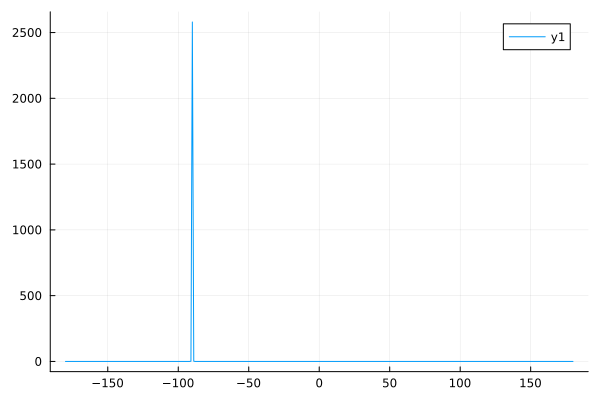

In [17]:
plot(az_list, γ_collection)

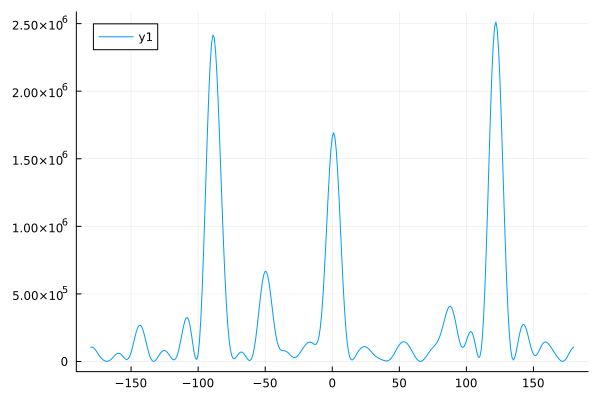

In [259]:
γ_collection, ___ = cbf(Sy, sensors_underwater, freq, c0);
plot(az_list, γ_collection)

In [335]:
#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
freq_interest = freq; # (Hz)
new_S = []
NFFT = size(new_sig, 1);
frequencies = sample_rate/NFFT*(0:(NFFT-1));
(_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );

for signal in eachcol(new_sig)
    S_interest = fft(signal);
    S_interest = S_interest[freq_idx];
    push!(new_S, S_interest);
end

In [342]:
P_test = [];
y = hcat(new_S) ./ maximum( abs.(new_S) );
for a in eachcol(A)
    push!(P_test, a' * y * y' * a);
end

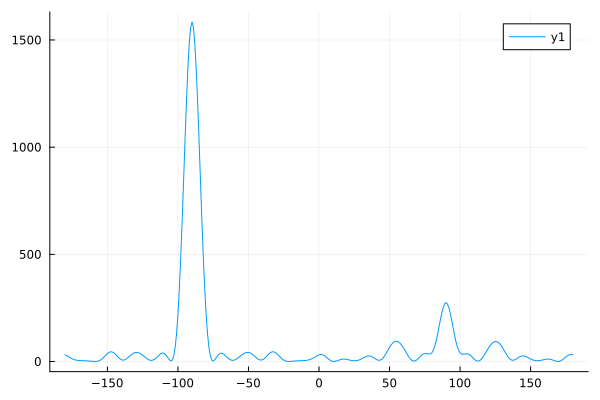

In [343]:
plot(az_list, P_test)

In [367]:
using Convex
using SCS

# size(A);
x = Variable(size(A, 2), 1);
# y = hcat(new_S);
ϵ = 0.0001;
objective = norm(x, 1);
constraints = [norm( y - A * x, 2) < ϵ];
problem = minimize(objective, constraints);
solve!(problem, SCS.Optimizer(););

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 724, constraints m: 805
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 723
	  q: soc vars: 81, qsize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 30676, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.42e+01  9.95e-01  5.09e+03 -2.55e+03  1.00e-01  1.53e-02 
   250| 4.29e+16  2.78e+15  6.24e+17  2.22e+19  7.46e-01  4.01e-02 
   

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/odas2/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [368]:
x_soln = evaluate(x)

361-element Vector{Float64}:
    0.009518818578879807
    0.01961204578283001
    0.02699457032180604
    0.03111588607181601
    0.031767662888905646
    0.029082945625312127
 -267.20268104856086
    0.015716609570178446
    0.006579083257236698
   -0.00298000042515165
    ⋮
   -0.0414552516689088
   -0.04748322626015409
   -0.04863052871130965
   -0.0451572322276738
   -0.03772479631824996
   -0.027314602786663117
   73.69560778566732
   -0.0024259498703415754
    0.009518818578879807

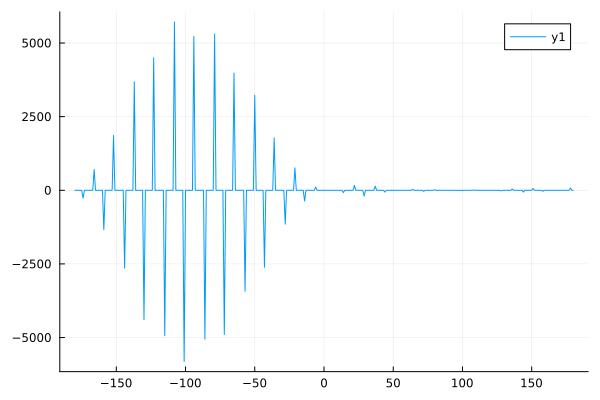

In [369]:
plot(az_list, x_soln)

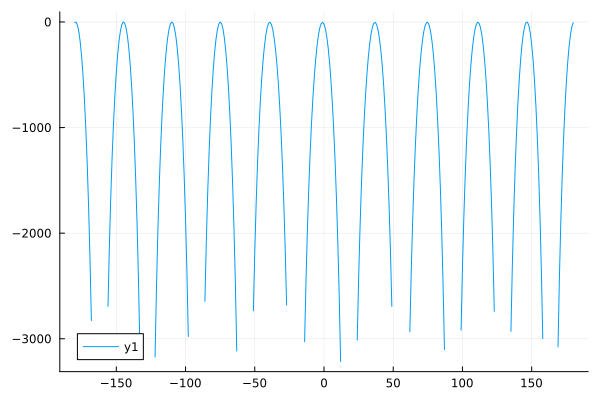

In [86]:
using Plots
P_db, az_max = predict_az(γ_collection, az_list);
plot(az_list, P_db)

In [240]:
include("./dbf_freeform.jl")
order = 3;
ψ_mat = create_ψ_matrix(sensors_underwater, order, freq, c0);
v = ones(Rational, 2*order+1); # Weights associated with DBF
v .//= size(v,1);
sensor_term = ψ_mat' * inv( ψ_mat * ψ_mat' );
A = Matrix{ComplexF64}(undef, num_sensors, size(az_list,1))
for (idx, az) in enumerate(az_list)
    γ = steering_matrix(az, order);
    h_dbf = sensor_term * conj(γ) * v;
    A[:, idx] = h_dbf
end

In [241]:
# SBL Algorithm
ϵ = 0.001; # Numerical Tolerance of Algorithm
γ_collection = Vector{Float64}(undef, length(az_list));
max_iter = 50;
K = 3;      # Number of Peaks
σ_noise = 0.1;
num_sensors = length(sensors_underwater);

# Initialization
γ_collection, ___ = dbf_coFree(Sy, sensors_underwater, order, freq, c0);
P_dbf, az_list = dbf_coFree(Sy, sensors_underwater, order, freq, c0);
for iter = 1:max_iter
    Γ = diagm(γ_collection);
    Σy = σ_noise .* I + A * Γ * A'; # Note: I is the identity Matrix

    # Start Finding new Amplitudes
    γ_new = Vector{ComplexF64}(undef, length(γ_collection));
    for (az_idx, az) in enumerate(az_list)
        a = A[:, az_idx];
        inv_y = inv(Σy);
        numo = tr(Sy * inv_y * a * a' * inv_y); # Is this PSD too by right?
        denom = a' * inv_y * a;         # Is this PSD by right?
        # println("Numerator: $(numo), Denomenator: $(denom)")
        γ_new[az_idx] = γ_collection[az_idx] .* abs(numo) / abs(denom);
    end
    γ_new = abs.(γ_new);

    # Find Peaks & Re-estimate Noise Parameter
    # ___, az_max_idx = findmax(γ_new); # Technically Find local Peaks
    ___, az_max_idx = find_peaks_k(γ_new, K);
    
    Am = A[:, az_max_idx];
    σ_noise = tr(I - Am * pinv(Am)) ./ (num_sensors - K);
    σ_noise = abs(σ_noise);

    err = norm(γ_new - γ_collection, 1) ./ norm(γ_collection, 1);
    println("At iter: $iter , Noise Value = $(σ_noise) w/ error: $err")
    # Stopping Criterion
    err < ϵ ? break : γ_collection = γ_new;
end

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


At iter: 1 , Noise Value = 0.999999999999994 w/ error: 683.4816361517572


At iter: 2 , Noise Value = 1.0000000000000022 w/ error: 1.1850475049085434


At iter: 3 , Noise Value = 1.0000000000000022 w/ error: 8.7495365667967


At iter: 4 , Noise Value = 0.9999999999999927 w/ error: 25.561869769486442


At iter: 5 , Noise Value = 0.9999999999999987 w/ error: 14024.465017729066


At iter: 6 , Noise Value = 1.0000000000000007 w/ error: 6.2005604467529665


At iter: 7 , Noise Value = 0.9999999999999958 w/ error: 0.9849696525164275


At iter: 8 , Noise Value = 0.9999999999999958 w/ error: 0.8858643639156466


At iter: 9 , Noise Value = 0.9999999999999958 w/ error: 0.863281000943151


At iter: 10 , Noise Value = 0.9999999999999958 w/ error: 2.817029234490172


At iter: 11 , Noise Value = 0.9999999999999998 w/ error: 0.8840977649824403


At iter: 12 , Noise Value = 1.0000000000000007 w/ error: 17.08209186734892


At iter: 13 , Noise Value = 1.0000000000000007 w/ error: 0.9395345428598652


At iter: 14 , Noise Value = 1.0000000000000007 w/ error: 17.57367662337962


At iter: 15 , Noise Value = 1.0000000000000007 w/ error: 0.20669485820730107


At iter: 16 , Noise Value = 1.0000000000000007 w/ error: 0.7141037163122909


At iter: 17 , Noise Value = 1.0000000000000007 w/ error: 0.2768282017694469


At iter: 18 , Noise Value = 1.0000000000000007 w/ error: 0.3711944884753024


At iter: 19 , Noise Value = 1.0000000000000007 w/ error: 1.294265147999663


At iter: 20 , Noise Value = 1.0000000000000007 w/ error: 0.8171592507173306


At iter: 21 , Noise Value = 1.0000000000000007 w/ error: 9.211152538711062


At iter: 22 , Noise Value = 1.0000000000000007 w/ error: 0.5060788494992553


At iter: 23 , Noise Value = 1.0000000000000007 w/ error: 0.9761696358359193


At iter: 24 , Noise Value = 1.0000000000000007 w/ error: 18.528928190124017


At iter: 25 , Noise Value = 0.9999999999999994 w/ error: 0.5130426317608932


At iter: 26 , Noise Value = 1.0000000000000007 w/ error: 0.6751846906033904


At iter: 27 , Noise Value = 1.0000000000000007 w/ error: 0.38118752108971005


At iter: 28 , Noise Value = 1.0000000000000007 w/ error: 2.556706834933259


At iter: 29 , Noise Value = 1.0000000000000007 w/ error: 0.23109431879702852


At iter: 30 , Noise Value = 0.9999999999999998 w/ error: 0.8683096344661085


At iter: 31 , Noise Value = 0.9999999999999998 w/ error: 6.038602706251573


At iter: 32 , Noise Value = 0.9999999999999958 w/ error: 0.7777914161631306


At iter: 33 , Noise Value = 1.0000000000000007 w/ error: 0.9970097793490814


At iter: 34 , Noise Value = 0.999999999999999 w/ error: 3.6137868616066338


At iter: 35 , Noise Value = 0.999999999999999 w/ error: 56.56111103945243


At iter: 36 , Noise Value = 0.999999999999999 w/ error: 114.08119348851585


At iter: 37 , Noise Value = 0.999999999999999 w/ error: 0.8558424920383262


At iter: 38 , Noise Value = 0.999999999999999 w/ error: 0.9313492307782786


At iter: 39 , Noise Value = 0.9999999999999998 w/ error: 0.9985180402037895


At iter: 40 , Noise Value = 0.9999999999999998 w/ error: 0.44993780194853317


At iter: 41 , Noise Value = 0.9999999999999998 w/ error: 0.35265579940948666


At iter: 42 , Noise Value = 0.9999999999999998 w/ error: 0.5566936916525305


At iter: 43 , Noise Value = 1.0000000000000002 w/ error: 0.21754355722417434


At iter: 44 , Noise Value = 0.9999999999999998 w/ error: 0.18018748865227827


At iter: 45 , Noise Value = 1.0000000000000002 w/ error: 0.06463636868805897


At iter: 46 , Noise Value = 1.0000000000000002 w/ error: 0.044790224789124575


At iter: 47 , Noise Value = 1.0 w/ error: 0.22493017497850976


At iter: 48 , Noise Value = 1.0000000000000002 w/ error: 0.4032182019016714


At iter: 49 , Noise Value = 1.0000000000000002 w/ error: 0.1456814439738559


At iter: 50 , Noise Value = 1.0 w/ error: 0.06458497213130504


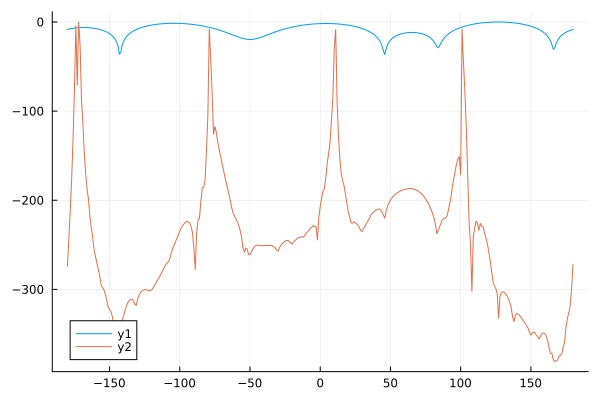

In [242]:
plot(az_list, pow2db.(P_dbf ./ maximum(P_dbf) ) )
plot!(az_list, pow2db.(γ_collection ./ maximum( γ_collection)))
# plot!(az_list, pow2db.(1 ./ γ_collection ./ maximum(1 ./ γ_collection)))

In [228]:
pkindices, properties = findpeaks1d(γ_collection);
az_list[pkindices]

2-element Vector{Float64}:
 -76.0
 105.0

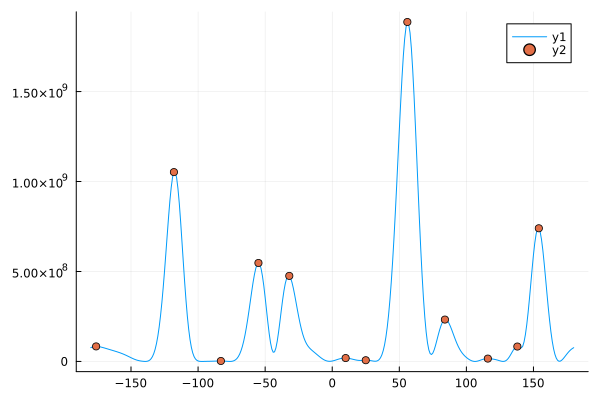

In [169]:
using FindPeaks1D
pkindices, properties = findpeaks1d(γ_collection)
plot(az_list, γ_collection);
plot!(az_list[pkindices], γ_collection[pkindices]; seriestype=:scatter)

In [138]:
az_list[pkindices]

6-element Vector{Int64}:
 -165
  -97
  -26
   15
   56
  127

In [113]:
az_list[pkindices]

2-element Vector{Int64}:
 -80
 100

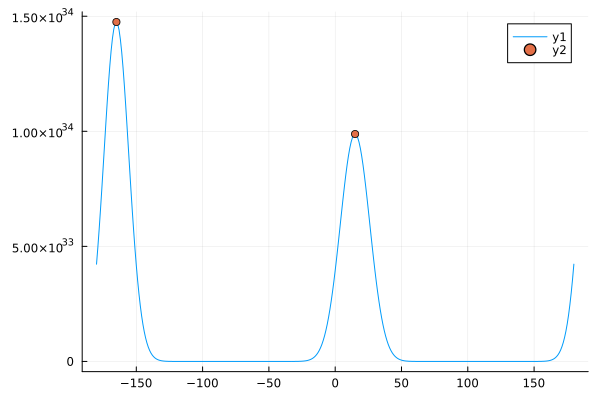

In [233]:
using FindPeaks1D
pkindices, properties = findpeaks1d(1 ./ γ_collection)
plot(az_list, 1 ./ γ_collection);
plot!(az_list[pkindices], 1 ./ γ_collection[pkindices]; seriestype=:scatter)

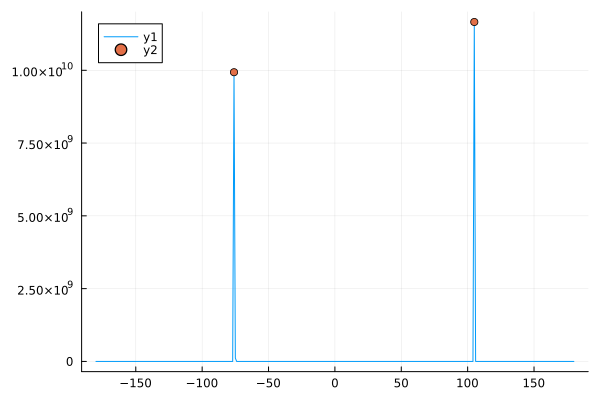

In [234]:
using FindPeaks1D
pkindices, properties = findpeaks1d( γ_collection)
plot(az_list,  γ_collection);
plot!(az_list[pkindices], γ_collection[pkindices]; seriestype=:scatter)

In [44]:
properties

Dict{String, Any}()

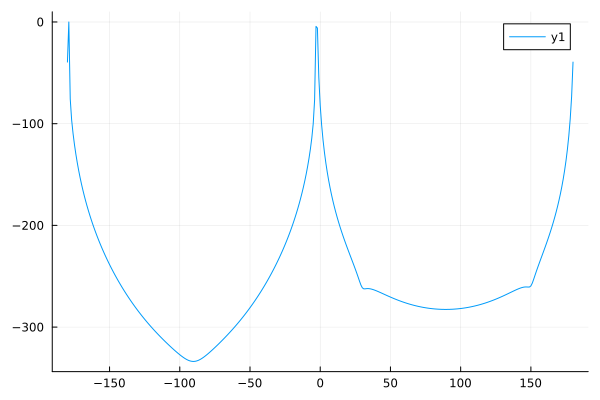

In [36]:
using Plots
P_db, az_max = predict_az(γ_collection, az_list);
plot(az_list, P_db)

In [31]:
using Peaks
findmaxima(γ_new)

UndefVarError: UndefVarError: γ_new not defined